In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

In [3]:
def sample_from_normal_dist(mu, sigma):
    return np.random.normal(mu)

In [4]:
class MultiArmedBandit:
    def __init__(self, arm_count, time_horizon, ground_truth_means):
        self.K = arm_count
        self.T = time_horizon
        self.curr_t = 0
        self.total_reward = 0
        self.ground_truth_means = ground_truth_means
        self.best_arm_mean = np.max(ground_truth_means)
        self.arm_rewards = np.zeros(self.K)
        self.reward_history = []
        self.regret_history = []
        self.empirical_means = np.zeros(self.K)
        self.arm_sample_count = np.zeros(self.K, dtype = np.int32)
        self.upper_confidence_bounds = np.zeros(self.K)
        self.lower_confidence_bounds = np.zeros(self.K)
    
    def ChooseBestArm(self):
        return np.argmax(self.upper_confidence_bounds)
    
    def UpdateEmpiricalMean(self, a, curr_sample):
        self.curr_t += 1
        self.arm_sample_count[a] += 1
        self.arm_rewards[a] += curr_sample
        self.empirical_means[a] = float(self.arm_rewards[a])/float(self.arm_sample_count[a])
    
    def UpdateConfidenceBounds(self, a):
        self.upper_confidence_bounds[a] = self.empirical_means[a] + np.sqrt(float(2*np.log(self.curr_t))/float(self.arm_sample_count[a]))
        self.lower_confidence_bounds[a] = self.empirical_means[a] - np.sqrt(float(2*np.log(self.curr_t))/float(self.arm_sample_count[a]))
        
    def Update(self, a, curr_sample):
        self.UpdateEmpiricalMean(a, curr_sample)
        self.UpdateConfidenceBounds(a)
    
    def SampleOnce(self):
        for arm in range(self.K):
            curr_sample = np.random.binomial(1, self.ground_truth_means[arm])
            self.Update(arm, curr_sample)
            self.total_reward += curr_sample
            self.reward_history.append(self.total_reward)
            self.regret_history.append(self.best_arm_mean*(len(self.reward_history))-self.total_reward)

    def BanditPlay(self):
        self.SampleOnce()
        for t in range(self.T-self.K):
            curr_arm = self.ChooseBestArm()
            curr_sample = np.random.binomial(1, self.ground_truth_means[curr_arm])
            self.Update(curr_arm, curr_sample)
            self.total_reward += curr_sample
            self.reward_history.append(self.total_reward)
            self.regret_history.append(self.best_arm_mean*(len(self.reward_history))-self.total_reward)

In [5]:
class MultiplePlayers:
    def __init__(self, a_num_players, a_margin, a_arm_count, a_time_horizon, a_arm0_ground_truth_means):
        self.m_num_players = a_num_players
        self.m_arm_count = a_arm_count
        self.m_margin = a_margin
        self.m_time_horizon = a_time_horizon
        self.m_ground_truth_means_array = np.zeros((self.m_num_players, self.m_arm_count))
        self.m_ground_truth_means_array[0,:] = a_arm0_ground_truth_means #np.random.uniform(size = self.m_arm_count)
        for col in range(self.m_arm_count):
            l = max(0.0, self.m_ground_truth_means_array[0,col]-self.m_margin)
            h = min(self.m_ground_truth_means_array[0,col]+self.m_margin, 1.0)
            self.m_ground_truth_means_array[1:,col] = np.random.uniform(low=l, high=h, size=self.m_num_players-1)
        self.m_players = [MultiArmedBandit(self.m_arm_count, self.m_time_horizon, self.m_ground_truth_means_array[r,:]) for r in range(self.m_num_players)]

    def UpdateConfidenceBounds(self):
        ucb_array = np.zeros((self.m_num_players-1, self.m_arm_count))
        for p in range(1,self.m_num_players):
            ucb_array[p-1,:]=self.m_players[p].upper_confidence_bounds
        min_ucbs = np.reshape(np.min(ucb_array, axis = 0), self.m_arm_count)
        self.m_players[0].upper_confidence_bounds = np.min([self.m_players[0].upper_confidence_bounds, min_ucbs+self.m_margin], axis=0)
    
    def UpdateConfidenceBounds_uniform_weighted(self):
        self.UpdateConfidenceBounds()
        ucb_array = np.zeros((self.m_num_players-1, self.m_arm_count))
        for a in range(self.m_arm_count):
            for p in range(1,self.m_num_players):
                n = self.m_players[0].arm_sample_count[a]
                m = self.m_players[p].arm_sample_count[a]
                X_a = self.m_players[0].arm_rewards[a]
                Y_a = self.m_players[p].arm_rewards[a]
                self.m_players[0].upper_confidence_bounds[a] = \
                    min(self.m_players[0].upper_confidence_bounds[a], \
                        (float(X_a+Y_a)/float(n+m))+np.sqrt(float(2*np.log(self.m_players[0].curr_t))/float(n+m))+float(m*self.m_margin)/float(n+m))
    
    def CalculateWeightedUCB(self, alpha, n, m, X, Y, epsilon):
        ucb_wt = alpha*float(X)/float(n) + (1-alpha)*float(Y)/float(m) + np.sqrt(2*np.log(self.m_players[0].curr_t)*(float(alpha**2)/float(n) + float((1-alpha)**2)/float(m))) + (1-alpha)*epsilon
        return ucb_wt
    
    def BestWeightedUCB(self, n, m, X, Y, epsilon):
        #UCB_min = lambda alpha: self.CalculateWeightedUCB(alpha, n=n, m=m, X=X, Y=Y, epsilon=epsilon)
        #print(UCB_min)
        #res = minimize(UCB_min,(0), method='SLSQP', bounds=((0,1),), options={'disp':False, 'maxiter':100})
        #print(res)
#         for alpha in np.arange(0.01, 1.00, 0.01):
#             ucb = self.CalculateWeightedUCB(alpha, n, m, X, Y, epsilon)
#             minUCB = min(minUCB, ucb)
        A=2*np.log(self.m_players[0].curr_t)*(float(1)/float(n)+float(1)/float(m))
        B=-4*np.log(self.m_players[0].curr_t)/float(m)
        C=2*np.log(self.m_players[0].curr_t)/float(m)
        D=float(X)/float(n)-float(Y)/float(m)-epsilon
        S=float(4*A*C*(np.power(D,2))-np.power(B*D,2))/float(4*np.power(A,3)-4*np.power(A*D,2))
        if(S<0):
            UCB_alpha_star = min(self.CalculateWeightedUCB(0, n, m, X, Y, epsilon), self.CalculateWeightedUCB(1, n, m, X, Y, epsilon))
        else:
            if(D>=0):
                alpha_star = -np.sqrt(S) - float(B)/float(2*A)
            else:
                alpha_star = np.sqrt(S) - float(B)/float(2*A)
            if(alpha_star<0):
                alpha_star = 0
            if(alpha_star>1):
                alpha_star = 1
            UCB_alpha_star = self.CalculateWeightedUCB(alpha_star, n, m, X, Y, epsilon)
        #print("res.fun is " + str(res.fun) + " and UCB(a*) is "+ str(UCB_alpha_star))
        return UCB_alpha_star
    
    def UpdateConfidenceBounds_best_weighted(self):
        self.UpdateConfidenceBounds()
        for a in range(self.m_arm_count):
            for p in range(1,self.m_num_players):
                n = self.m_players[0].arm_sample_count[a]
                m = self.m_players[p].arm_sample_count[a]
                X_a = self.m_players[0].arm_rewards[a]
                Y_a = self.m_players[p].arm_rewards[a]
                best_ucb = self.BestWeightedUCB(n,m,X_a,Y_a,self.m_margin)
                self.m_players[0].upper_confidence_bounds[a] = min(self.m_players[0].upper_confidence_bounds[a], best_ucb)

    def ConcurrentBanditPlay(self):
        '''
            All the players play in parallel
        '''
        for player in self.m_players:
            player.SampleOnce()
        self.UpdateConfidenceBounds()
        for t in range(self.m_time_horizon-self.m_arm_count):
            for p in range(self.m_num_players):
                p_arm = self.m_players[p].ChooseBestArm()
                p_sample = np.random.binomial(1, self.m_players[p].ground_truth_means[p_arm])
                self.m_players[p].Update(p_arm, p_sample)
                self.m_players[p].total_reward += p_sample
                self.m_players[p].reward_history.append(self.m_players[p].total_reward)
                self.m_players[p].regret_history.append(self.m_players[p].best_arm_mean*(len(self.m_players[p].reward_history))-self.m_players[p].total_reward)
            self.UpdateConfidenceBounds()
            
    def ConcurrentBanditPlay_weighted_updates(self):
        '''
            All the players play in parallel, alpha=n/n+m (uniform weighting)
        '''
        for player in self.m_players:
            player.SampleOnce()
        self.UpdateConfidenceBounds_uniform_weighted()
        for t in range(self.m_time_horizon-self.m_arm_count):
            for p in range(self.m_num_players):
                p_arm = self.m_players[p].ChooseBestArm()
                p_sample = np.random.binomial(1, self.m_players[p].ground_truth_means[p_arm])
                self.m_players[p].Update(p_arm, p_sample)
                self.m_players[p].total_reward += p_sample
                self.m_players[p].reward_history.append(self.m_players[p].total_reward)
                self.m_players[p].regret_history.append(self.m_players[p].best_arm_mean*(len(self.m_players[p].reward_history))-self.m_players[p].total_reward)
            self.UpdateConfidenceBounds_uniform_weighted()
    
    def ConcurrentBanditPlay_best_weighting(self):
        '''
            All the players play in parallel, weighting is corresponding to best alpha
        '''
        for player in self.m_players:
            player.SampleOnce()
        self.UpdateConfidenceBounds_best_weighted()
        for t in range(self.m_time_horizon-self.m_arm_count):
            for p in range(self.m_num_players):
                p_arm = self.m_players[p].ChooseBestArm()
                p_sample = np.random.binomial(1, self.m_players[p].ground_truth_means[p_arm])
                self.m_players[p].Update(p_arm, p_sample)
                self.m_players[p].total_reward += p_sample
                self.m_players[p].reward_history.append(self.m_players[p].total_reward)
                self.m_players[p].regret_history.append(self.m_players[p].best_arm_mean*(len(self.m_players[p].reward_history))-self.m_players[p].total_reward)
            self.UpdateConfidenceBounds_best_weighted()
    
    def ConcurrentBanditPlay_warmstart(self, warm_start_time):
        '''
            Other players play for a while and then base player joins in
        '''
        # Warm start phase
        for player in self.m_players[1:]:
            player.SampleOnce()
        for player in self.m_players[1:]:
            for t in range(warm_start_time-self.m_arm_count):
                p_arm = player.ChooseBestArm()
                p_sample = np.random.binomial(1, player.ground_truth_means[p_arm])
                player.Update(p_arm, p_sample)
                player.total_reward += p_sample
                player.reward_history.append(player.total_reward)
                player.regret_history.append(player.best_arm_mean*(len(player.reward_history))-player.total_reward)

        # Exploration phase
        self.m_players[0].SampleOnce()
        self.UpdateConfidenceBounds_uniform_weighted()
        for t in range(self.m_time_horizon-self.m_arm_count):
            for p in range(self.m_num_players):
                p_arm = self.m_players[p].ChooseBestArm()
                p_sample = np.random.binomial(1, self.m_players[p].ground_truth_means[p_arm])
                self.m_players[p].Update(p_arm, p_sample)
                self.m_players[p].total_reward += p_sample
                self.m_players[p].reward_history.append(self.m_players[p].total_reward)
                self.m_players[p].regret_history.append(self.m_players[p].best_arm_mean*(len(self.m_players[p].reward_history))-self.m_players[p].total_reward)
            self.UpdateConfidenceBounds_uniform_weighted()

In [6]:
class MultiplePlayers_variable_epsilon:
    def __init__(self, a_num_players, a_arm_count, a_time_horizon, a_arm0_ground_truth_means):
        self.m_num_players = a_num_players
        self.m_arm_count = a_arm_count
        self.m_time_horizon = a_time_horizon
        self.epsilon = np.zeros((self.m_num_players-1, self.m_arm_count))
        self.m_ground_truth_means_array = np.zeros((self.m_num_players, self.m_arm_count))
        self.m_ground_truth_means_array[0,:] = a_arm0_ground_truth_means #np.random.uniform(size = self.m_arm_count)
        for col in range(self.m_arm_count):
            curr_margin = abs(np.random.normal(scale=0.1))
            l = max(0.0, self.m_ground_truth_means_array[0,col]-curr_margin)
            h = min(self.m_ground_truth_means_array[0,col]+curr_margin, 1.0)
            self.m_ground_truth_means_array[1:,col] = np.random.uniform(low=l, high=h, size=self.m_num_players-1)
        self.m_players = [MultiArmedBandit(self.m_arm_count, self.m_time_horizon, self.m_ground_truth_means_array[r,:]) for r in range(self.m_num_players)]
        print(self.m_ground_truth_means_array)

    def UpdateEpsilon(self):
        for p in range(1, self.m_num_players):
            for a in range(self.m_arm_count):
                self.epsilon[p-1][a] = abs(self.m_players[0].empirical_means[a]-self.m_players[p].empirical_means[a])
                #self.epsilon[p-1][a] = max(self.m_players[p].upper_confidence_bounds[a]-self.m_players[0].lower_confidence_bounds[a], \
                                          #self.m_players[0].upper_confidence_bounds[a]-self.m_players[p].lower_confidence_bounds[a])
        #print(self.epsilon)
    
    def UpdateConfidenceBounds(self):
        ucb_array = np.zeros((self.m_num_players-1, self.m_arm_count))
        for p in range(1,self.m_num_players):
            ucb_array[p-1,:]=self.m_players[p].upper_confidence_bounds
        min_ucbs = np.reshape(np.min(ucb_array+self.epsilon, axis = 0), self.m_arm_count)
        self.m_players[0].upper_confidence_bounds = np.min([self.m_players[0].upper_confidence_bounds, min_ucbs], axis=0)

    def CalculateWeightedUCB(self, alpha, n, m, X, Y, epsilon):
        ucb_wt = alpha*float(X)/float(n) + (1-alpha)*float(Y)/float(m) + np.sqrt(2*np.log(self.m_players[0].curr_t)*(float(alpha**2)/float(n) + float((1-alpha)**2)/float(m))) + (1-alpha)*epsilon
        return ucb_wt
    
    def BestWeightedUCB(self, n, m, X, Y, epsilon):
        #UCB_min = lambda alpha: self.CalculateWeightedUCB(alpha, n=n, m=m, X=X, Y=Y, epsilon=epsilon)
        #print(UCB_min)
        #res = minimize(UCB_min,(0), method='SLSQP', bounds=((0,1),), options={'disp':False, 'maxiter':100})
        #print(res)
#         for alpha in np.arange(0.01, 1.00, 0.01):
#             ucb = self.CalculateWeightedUCB(alpha, n, m, X, Y, epsilon)
#             minUCB = min(minUCB, ucb)
        A=2*np.log(self.m_players[0].curr_t)*(float(1)/float(n)+float(1)/float(m))
        B=-4*np.log(self.m_players[0].curr_t)/float(m)
        C=2*np.log(self.m_players[0].curr_t)/float(m)
        D=float(X)/float(n)-float(Y)/float(m)-epsilon
        S=float(4*A*C*(np.power(D,2))-np.power(B*D,2))/float(4*np.power(A,3)-4*np.power(A*D,2))
        if(S<0):
            UCB_alpha_star = min(self.CalculateWeightedUCB(0, n, m, X, Y, epsilon), self.CalculateWeightedUCB(1, n, m, X, Y, epsilon))
        else:
            if(D>=0):
                alpha_star = -np.sqrt(S) - float(B)/float(2*A)
            else:
                alpha_star = np.sqrt(S) - float(B)/float(2*A)
            if(alpha_star<0):
                alpha_star = 0
            if(alpha_star>1):
                alpha_star = 1
            UCB_alpha_star = self.CalculateWeightedUCB(alpha_star, n, m, X, Y, epsilon)
        #print("res.fun is " + str(res.fun) + " and UCB(a*) is "+ str(UCB_alpha_star))
        return UCB_alpha_star
    
    def UpdateConfidenceBounds_best_weighted(self):
        self.UpdateConfidenceBounds()
        for a in range(self.m_arm_count):
            for p in range(1,self.m_num_players):
                n = self.m_players[0].arm_sample_count[a]
                m = self.m_players[p].arm_sample_count[a]
                X_a = self.m_players[0].arm_rewards[a]
                Y_a = self.m_players[p].arm_rewards[a]
                best_ucb = self.BestWeightedUCB(n,m,X_a,Y_a,self.epsilon[p-1][a])
                self.m_players[0].upper_confidence_bounds[a] = min(self.m_players[0].upper_confidence_bounds[a], best_ucb)

    def ConcurrentBanditPlay_best_weighting(self):
        '''
            All the players play in parallel and epsilon updates are based on the best estimate so far
        '''
        for player in self.m_players:
            player.SampleOnce()
        self.UpdateEpsilon()
        self.UpdateConfidenceBounds_best_weighted()
        for t in range(self.m_time_horizon-self.m_arm_count):
            for p in range(self.m_num_players):
                p_arm = self.m_players[p].ChooseBestArm()
                p_sample = np.random.binomial(1, self.m_players[p].ground_truth_means[p_arm])
                self.m_players[p].Update(p_arm, p_sample)
                self.m_players[p].total_reward += p_sample
                self.m_players[p].reward_history.append(self.m_players[p].total_reward)
                self.m_players[p].regret_history.append(self.m_players[p].best_arm_mean*(len(self.m_players[p].reward_history))-self.m_players[p].total_reward)
            self.UpdateEpsilon()
            self.UpdateConfidenceBounds_best_weighted()

In [32]:
class MultiplePlayers_epsilon_lower_bound:
    def __init__(self, a_num_players, a_arm_count, a_base_time_horizon, a_supp_time_horizon, a_arm0_ground_truth_means):
        self.m_num_players = a_num_players
        self.m_arm_count = a_arm_count
        self.m_base_time_horizon = a_base_time_horizon
        self.m_supp_time_horizon = a_supp_time_horizon
        self.epsilon_estimate = np.zeros((self.m_num_players-1, self.m_arm_count))+0.5
        self.epsilon_average = np.zeros((self.m_num_players-1, self.m_arm_count))
        self.m_ground_truth_means_array = np.zeros((self.m_num_players, self.m_arm_count))
        
        # Set the base player's ground truth means
        self.m_ground_truth_means_array[0,:] = a_arm0_ground_truth_means #np.random.uniform(size = self.m_arm_count)
        
        # Set the supporting players' ground truth means
        curr_margin = np.random.normal(scale=0.1, size=(self.m_num_players-1,self.m_arm_count))
        self.m_ground_truth_means_array[1:,:] = np.clip(self.m_ground_truth_means_array[0,:]+curr_margin, 0, 1)
        
        self.m_players = [MultiArmedBandit(self.m_arm_count, self.m_supp_time_horizon, self.m_ground_truth_means_array[r,:]) for r in range(self.m_num_players)]
        self.m_players[0].T = self.m_base_time_horizon
        for p in range(1, self.m_num_players):
            self.m_players[p].BanditPlay()
        #print(self.m_ground_truth_means_array)

    def UpdateEpsilon(self, a, p_delta=0.5):
        for p in range(1, self.m_num_players):
            threshold = int(2*np.log(float(1)/float(p_delta))/float(self.epsilon_estimate[p-1][a]**2))
            if(self.m_players[0].arm_sample_count[a]>threshold):
                if(self.epsilon_average[p-1][a]<2*self.epsilon_estimate[p-1][a]):
                    self.epsilon_estimate[p-1][a] /= 2
    
    def UpdateConfidenceBounds(self):
        ucb_array = np.zeros((self.m_num_players-1, self.m_arm_count))
        for p in range(1,self.m_num_players):
            ucb_array[p-1,:]=self.m_players[p].upper_confidence_bounds
        min_ucbs = np.reshape(np.min(ucb_array+self.epsilon_estimate, axis = 0), self.m_arm_count)
        self.m_players[0].upper_confidence_bounds = np.min([self.m_players[0].upper_confidence_bounds, min_ucbs], axis=0)

    def CalculateWeightedUCB(self, alpha, n, m, X, Y, epsilon):
        ucb_wt = alpha*float(X)/float(n) + (1-alpha)*float(Y)/float(m) + np.sqrt(2*np.log(self.m_players[0].curr_t)*(float(alpha**2)/float(n) + float((1-alpha)**2)/float(m))) + (1-alpha)*epsilon
        return ucb_wt
    
    def BestWeightedUCB(self, n, m, X, Y, epsilon):
        #UCB_min = lambda alpha: self.CalculateWeightedUCB(alpha, n=n, m=m, X=X, Y=Y, epsilon=epsilon)
        #print(UCB_min)
        #res = minimize(UCB_min,(0), method='SLSQP', bounds=((0,1),), options={'disp':False, 'maxiter':100})
        #print(res)
#         for alpha in np.arange(0.01, 1.00, 0.01):
#             ucb = self.CalculateWeightedUCB(alpha, n, m, X, Y, epsilon)
#             minUCB = min(minUCB, ucb)
        A=2*np.log(self.m_players[0].curr_t)*(float(1)/float(n)+float(1)/float(m))
        B=-4*np.log(self.m_players[0].curr_t)/float(m)
        C=2*np.log(self.m_players[0].curr_t)/float(m)
        D=float(X)/float(n)-float(Y)/float(m)-epsilon
        S=float(4*A*C*(np.power(D,2))-np.power(B*D,2))/float(4*np.power(A,3)-4*np.power(A*D,2))
        if(S<0):
            UCB_alpha_star = min(self.CalculateWeightedUCB(0, n, m, X, Y, epsilon), self.CalculateWeightedUCB(1, n, m, X, Y, epsilon))
        else:
            if(D>=0):
                alpha_star = -np.sqrt(S) - float(B)/float(2*A)
            else:
                alpha_star = np.sqrt(S) - float(B)/float(2*A)
            if(alpha_star<0):
                alpha_star = 0
            if(alpha_star>1):
                alpha_star = 1
            UCB_alpha_star = self.CalculateWeightedUCB(alpha_star, n, m, X, Y, epsilon)
        #print("res.fun is " + str(res.fun) + " and UCB(a*) is "+ str(UCB_alpha_star))
        return UCB_alpha_star
    
    def UpdateConfidenceBounds_best_weighted(self):
        self.UpdateConfidenceBounds()
        for a in range(self.m_arm_count):
            for p in range(1,self.m_num_players):
                n = self.m_players[0].arm_sample_count[a]
                m = self.m_players[p].arm_sample_count[a]
                X_a = self.m_players[0].arm_rewards[a]
                Y_a = self.m_players[p].arm_rewards[a]
                best_ucb = self.BestWeightedUCB(n,m,X_a,Y_a,self.epsilon_estimate[p-1][a])
                self.m_players[0].upper_confidence_bounds[a] = min(self.m_players[0].upper_confidence_bounds[a], best_ucb)

    def BanditPlay_best_weighting(self):
        '''
            The base player plays and epsilon updates are based on the best estimate so far
        '''
        self.m_players[0].SampleOnce()
        for p in range(1, self.m_num_players):
            for a in range(self.m_arm_count):
                self.epsilon_average[p-1][a] = abs(self.m_players[0].empirical_means[a]-self.m_players[p-1].empirical_means[a])
        for arm in range(self.m_arm_count):
            self.UpdateEpsilon(a=arm)
        self.UpdateConfidenceBounds_best_weighted()
        for t in range(self.m_base_time_horizon-self.m_arm_count):
            p_arm = self.m_players[0].ChooseBestArm()
            #if(t<50):
                #print(p_arm)
            p_sample = np.random.binomial(1, self.m_players[0].ground_truth_means[p_arm])
            self.m_players[0].Update(p_arm, p_sample)
            self.m_players[0].total_reward += p_sample
            self.m_players[0].reward_history.append(self.m_players[0].total_reward)
            self.m_players[0].regret_history.append(self.m_players[0].best_arm_mean*(len(self.m_players[0].reward_history))-self.m_players[0].total_reward)
            for p in range(1, self.m_num_players):
                p_arm_sample_count = self.m_players[0].arm_sample_count[p_arm]
                self.epsilon_average[p-1][p_arm] = self.epsilon_average[p-1][p_arm]*float(p_arm_sample_count-1)/float(p_arm_sample_count) + abs(p_sample-self.m_players[p].empirical_means[p_arm])/float(p_arm_sample_count)
            self.UpdateEpsilon(a=p_arm)
            self.UpdateConfidenceBounds_best_weighted()

Exp 0 done
Exp 1 done
Exp 2 done
Exp 3 done
Exp 4 done
Exp 5 done
Exp 6 done
Exp 7 done
Exp 8 done
Exp 9 done


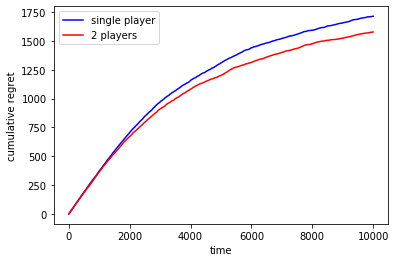

In [33]:
def experiment1(K, T, epsilon):
    regret_histories = []
    n_arms = K
    time_horizon = T
    low=0.01
    high=0.1
    M = MultiArmedBandit(n_arms, time_horizon, np.concatenate((np.linspace(low, high, num=n_arms-1), np.array([0.9]))))
    M.BanditPlay()
    regret_histories.append(M.regret_history)

    max_num_players = 2
    for p_count in range(2,max_num_players+1):
        p_multiple = MultiplePlayers(p_count, epsilon, n_arms, time_horizon, np.concatenate((np.linspace(low, high, num=n_arms-1), np.array([0.9]))))
        p_multiple.ConcurrentBanditPlay_best_weighting()
        regret_histories.append(p_multiple.m_players[0].regret_history)
    return regret_histories

def experiment2(K, T, delta):
    regret_histories = []
    n_arms = K
    time_horizon = T
    low=0.5
    high=0.5
    M = MultiArmedBandit(n_arms, time_horizon, np.concatenate((np.array([0.5-delta]), np.linspace(low, high, num=n_arms-2), np.array([0.5+delta]))))
    M.BanditPlay()
    regret_histories.append(M.regret_history)

    max_num_players = 2
    for p_count in range(2,max_num_players+1):
        p_multiple = MultiplePlayers_variable_epsilon(p_count, n_arms, time_horizon, np.concatenate((np.array([0.5-delta]) ,np.linspace(low, high, num=n_arms-2), np.array([0.5+delta]))))
        p_multiple.ConcurrentBanditPlay_best_weighting()
        regret_histories.append(p_multiple.m_players[0].regret_history)
    return regret_histories

def experiment3(K, T_base, T_supp, delta):
    regret_histories = []
    n_arms = K
    base_time_horizon = T_base
    supp_time_horizon = T_supp
    low=0.5
    high=0.5
    M = MultiArmedBandit(n_arms, base_time_horizon, np.concatenate((np.linspace(low, high, num=n_arms-1), np.array([0.5+delta]))))
    M.BanditPlay()
    regret_histories.append(M.regret_history)

    max_num_players = 2
    for p_count in range(2,max_num_players+1):
        p_multiple = MultiplePlayers_epsilon_lower_bound(p_count, n_arms, base_time_horizon, supp_time_horizon, np.concatenate((np.linspace(low, high, num=n_arms-1), np.array([0.5+delta]))))
        p_multiple.BanditPlay_best_weighting()
        regret_histories.append(p_multiple.m_players[0].regret_history)
    return regret_histories

exp_count = 10
K=50
T_base=10000
T_supp=500
delta=0.4
epsilon=0.1
avg_1 = np.zeros(T_base)
avg_2 = np.zeros(T_base)
avg_3 = np.zeros(T_base)
for e in range(exp_count):
    curr_avg_1, curr_avg_2 = experiment3(K, T_base, T_supp, delta)
    avg_1 = (float(e)/float(e+1))*avg_1 + (1.0/float(e+1))*np.array(curr_avg_1)
    avg_2 = (float(e)/float(e+1))*avg_2 + (1.0/float(e+1))*np.array(curr_avg_2)
    #avg_3 = (float(e)/float(e+1))*avg_3 + (1.0/float(e+1))*np.array(curr_avg_3)
    print("Exp " + str(e) + " done")
plt.plot(avg_1, color = "b", label = "single player")
plt.plot(avg_2, color = "r", label = "2 players")
#plt.plot(avg_3, color = "g", label = "3 players")

plt.legend(loc="best")
plt.xlabel("time")
plt.ylabel("cumulative regret")
#plt.show()
plt.savefig("epsilon_lower_bound_prob_delta_0p5.jpg", dpi=1000)

In [87]:
# Variable epsilon experiments
p_multiple

NameError: name 'p_multiple' is not defined

In [ ]:
plt.plot(avg_1, color = "b", label = "single player")
plt.plot(avg_2, color = "r", label = "2 players")
#plt.plot(avg_3, color = "g", label = "3 players")

plt.legend(loc="best")
plt.xlabel("time")
plt.ylabel("cumulative regret")
#plt.show()
plt.savefig("2a_best_weighting.jpg", dpi=1000)

In [ ]:
print(M.ground_truth_means)

In [ ]:
print(M.empirical_means)

In [ ]:
print(M.arm_sample_count)

In [ ]:
print(M.arm_rewards)

In [ ]:
print(M.total_reward)

In [ ]:
# Simulating with multiple players

for p_count in range(2,11):
    p_multiple = MultiplePlayers(p_count, 0.05, 9, 1000, np.linspace(0.1, 0.9, num=9))
    p_multiple.ConcurrentBanditPlay()
    plt.plot(p_multiple.m_players[0].reward_history, color = str(p_count/10), label = str(p_count))

plt.show()
players_2 = MultiplePlayers(10, 0.05, 9, 1000, np.linspace(0.1, 0.9, num=9))
#print(players_2.m_ground_truth_means_array)

In [ ]:
players_2.ConcurrentBanditPlay()

In [ ]:
print(players_2.m_ground_truth_means_array)

In [ ]:
print(players_2.m_players[0].ground_truth_means)
print(players_2.m_players[0].empirical_means)
print(players_2.m_players[0].arm_rewards)
print(players_2.m_players[0].arm_sample_count)

In [ ]:
plt.plot(players_2.m_players[5].ground_truth_means)
plt.show()

In [15]:
np.linspace(0.1, 0.1, num=9)

array([0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1])

In [ ]:
print(players_2.m_players[0].total_reward)